In [1]:
import torch
import numpy as np
import ternary
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from ensemblecalibration.data.multiclass_dirichlet import (
    exp_dirichlet,
    sample_p_bar_h1,
    sample_ensemble_preds,
    sample_dir_params,
    sample_weights_h0,
)
from ensemblecalibration.utils.projections import project_points2D
from ensemblecalibration.utils.helpers import calculate_pbar
from ensemblecalibration.meta_model.losses import SKCELoss, LpLoss, MMDLoss, BrierLoss
from ensemblecalibration.cal_estimates.kde_ece import get_bandwidth


In [17]:
# SET PARAMETERS
N_SAMPLES = 1000
N_CLASSES = 3
N_MODELS = 10
X_BOUNDS = [0, 1]
UNCERTAINTY = lambda x : x


### Dirichlet experiment for $K=3$ classes

In [13]:
x_inst = torch.tensor(np.random.uniform(X_BOUNDS[0], X_BOUNDS[1], N_SAMPLES))
# sort instances
x_inst = torch.sort(x_inst).values

dir_prior = torch.distributions.Dirichlet(torch.ones(N_CLASSES)).sample((N_SAMPLES,))
print(dir_prior)
dir_params = sample_dir_params(x_inst, dir_prior, uncertainty=UNCERTAINTY)
print(dir_params)
preds = torch.distributions.Dirichlet(dir_params).sample((N_MODELS,))
# swap first and second axis of preds
preds = preds.permute(1,0,2)

print(preds[900,:,:])

tensor([[0.2813, 0.1418, 0.5769],
        [0.8275, 0.1365, 0.0361],
        [0.6892, 0.2537, 0.0571],
        ...,
        [0.3563, 0.3815, 0.2622],
        [0.4228, 0.5056, 0.0716],
        [0.5160, 0.2050, 0.2789]])
tensor([[ 72.4434,  36.5292, 148.5982],
        [212.6317,  35.0668,   9.2737],
        [167.3577,  61.5958,  13.8710],
        ...,
        [  1.0621,   1.1370,   0.7816],
        [  1.2575,   1.5039,   0.2129],
        [  1.5341,   0.6094,   0.8292]], dtype=torch.float64)
tensor([[0.4953, 0.0268, 0.4779],
        [0.6086, 0.3207, 0.0707],
        [0.3767, 0.5559, 0.0673],
        [0.2890, 0.1514, 0.5597],
        [0.8499, 0.0023, 0.1479]], dtype=torch.float64)


/Users/mirajuergens/Library/CloudStorage/OneDrive-UGent/Code/EnsembleCalibration/ensemblecalibration/data/multiclass_dirichlet.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params_m = torch.tensor(params_m)


In [18]:
5# sample ensemble predictions and dirichlet parameters
# instances
x_inst = torch.tensor(np.random.uniform(X_BOUNDS[0], X_BOUNDS[1], N_SAMPLES))
# sort instances
x_inst = torch.sort(x_inst).values
# ensemble predictions and dirichlet para,eters
p_preds, dir_params = sample_ensemble_preds(
    x_inst=x_inst,
    n_ens=N_MODELS,
    n_classes=N_CLASSES,
    uncertainty=UNCERTAINTY,
)
# sample weights
weights_l_x_dep = sample_weights_h0(x_inst,
                              n_members=N_MODELS,
                              x_dep=True,
                              deg=2)
weights_l_const = sample_weights_h0(x_inst,
                              n_members=N_MODELS,
                              x_dep=False,
                              deg=2)
p_bar_h0_xdep = calculate_pbar(weights_l_x_dep, p_preds
                               )
p_bar_h0_const = calculate_pbar(weights_l_const, p_preds
                               )

# now h1 
p_bar_h1_1, _ = sample_p_bar_h1(x_inst, p_preds=p_preds,
                              dir_params=dir_params,
                              deg_h1=0.1)
p_bar_h1_2, _ = sample_p_bar_h1(x_inst, p_preds=p_preds,
                                dir_params=dir_params,
                                deg_h1=.5)
p_bar_h1_3, _ = sample_p_bar_h1(x_inst, p_preds=p_preds,
                                dir_params=dir_params,
                                deg_h1=.9)

tensor([[0.2664, 0.1524, 0.5812],
        [0.2708, 0.2221, 0.5072],
        [0.2920, 0.2823, 0.4257],
        ...,
        [0.0011, 0.8790, 0.1199],
        [0.4470, 0.1210, 0.4320],
        [0.1227, 0.5470, 0.3303]])


<>:28: SyntaxWarning: invalid escape sequence '\{'
<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:44: SyntaxWarning: invalid escape sequence '\l'
<>:28: SyntaxWarning: invalid escape sequence '\{'
<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:44: SyntaxWarning: invalid escape sequence '\l'
/var/folders/mf/gnm849bj4fq5xnqhl_bdhf9m0000gn/T/ipykernel_61906/1088094947.py:28: SyntaxWarning: invalid escape sequence '\{'
  label="$\{f^{(i)}\}_{i=1}^{5}$",
/var/folders/mf/gnm849bj4fq5xnqhl_bdhf9m0000gn/T/ipykernel_61906/1088094947.py:43: SyntaxWarning: invalid escape sequence '\l'
  tax.scatter([p_bar_x_h0_const], marker="o", color="blue", label="$p_{\lambda}$")
/var/folders/mf/gnm849bj4fq5xnqhl_bdhf9m0000gn/T/ipykernel_61906/1088094947.py:44: SyntaxWarning: invalid escape sequence '\l'
  tax.scatter([p_bar_x_h0_xdep], marker="o", color="green", label="$p_{\lambda_x}$")


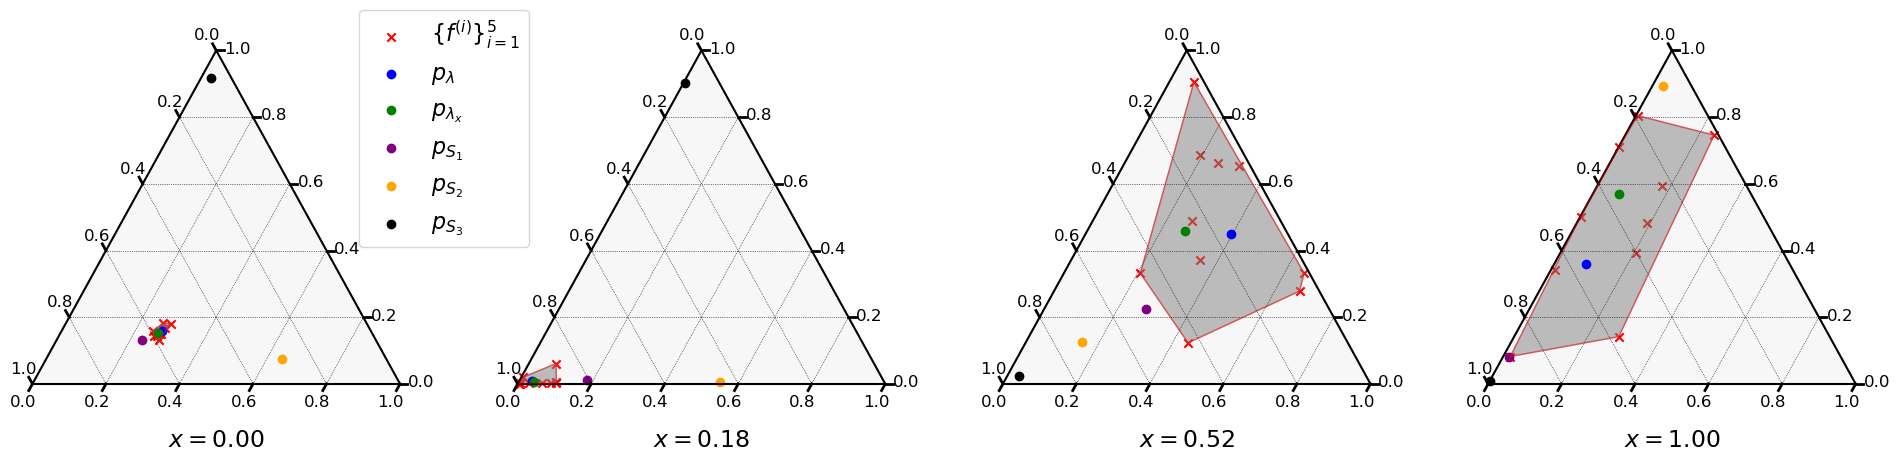

In [23]:
x_list = [0, 160, 500, 999]
fig, ax = plt.subplots(1, len(x_list), figsize=(24, 5))
for i, x in enumerate(x_list):
    tax = ternary.TernaryAxesSubplot(ax=ax[i], scale=1.0)
    p_preds_x = p_preds[x, :, :].detach().numpy()
    p_bar_x_h0_const = p_bar_h0_const[x, :].detach().numpy()
    p_bar_x_h0_xdep = p_bar_h0_xdep[x, :].detach().numpy()
    p_bar_x_h1_1 = p_bar_h1_1[x, :].detach().numpy()
    p_bar_x_h1_2 = p_bar_h1_2[x, :].detach().numpy()
    p_bar_x_h1_3 = p_bar_h1_3[x, :].detach().numpy()
    p_preds_2d = project_points2D(p_preds_x)
    hull = ConvexHull(p_preds_2d)
    hull_vertices = p_preds_x[hull.vertices]

    # fig, tax = ternary.figure(scale=1)
    tax.boundary()
    tax.gridlines(multiple=0.2, color="black", )
    # ticks of axes
    tax.ticks(axis='lbr', multiple=0.2, linewidth=2, offset=0.02, tick_formats="%.1f", fontsize=12)
    # remove outer axes and boxes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis("off")

    tax.scatter(
        list(map(tuple, p_preds_x)),
        marker="x",
        color="red",
        label="$\{f^{(i)}\}_{i=1}^{5}$",
    )
    for simplex in hull.simplices:
        point1 = tuple(p_preds_x[simplex[0]])
        point2 = tuple(p_preds_x[simplex[1]])
        tax.line(point1, point2, linewidth=1.0, color="red", alpha=0.5)

    polygon = Polygon(
        list(map(tuple, project_points2D(hull_vertices))),
        closed=True,
        color="grey",
        alpha=0.5,
    )
    tax.get_axes().add_patch(polygon)
   # plot the true point
    tax.scatter([p_bar_x_h0_const], marker="o", color="blue", label="$p_{\lambda}$")
    tax.scatter([p_bar_x_h0_xdep], marker="o", color="green", label="$p_{\lambda_x}$")
    tax.scatter([p_bar_x_h1_1], marker="o", color="purple", label="$p_{S_1}$")
    tax.scatter([p_bar_x_h1_2], marker="o", color="orange", label="$p_{S_2}$")
    tax.scatter([p_bar_x_h1_3], marker="o", color="black", label="$p_{S_3}$")
    if i == 0:
        # set specific location for legend: upper right with overlap
        tax.legend(fontsize=16, loc="upper right", bbox_to_anchor=(1.3, 1.1))
    x_val = x_inst[x]
    # leave space below title
    # set title below plot
    tax.set_title(f"$x = {{{x_val: .2f}}}$", fontsize=17, pad=10, y=-0.1)

plt.savefig("../figures/simplex_polygon_instance_unc.png", dpi=300)
plt.savefig("../figures/simplex_polygon_instance_unc.svg")

## Testing

In [20]:
x_inst = np.linspace(0, 1, 100)

In [46]:
import numpy as np

def generate_dirichlet_params(x, base_value, uncertainty, min_alpha=0.01):
    """
    Generate Dirichlet parameters ensuring that they are always positive.
    """
    noise = np.random.randn(len(base_value)) * uncertainty
    alpha_k = base_value + noise
    alpha_k = np.maximum(alpha_k, min_alpha)  # Ensure alpha is positive
    return alpha_k

# Parameters
K = 5  # Number of ensemble members
C = 3  # Number of classes
X = np.linspace(0, 1, num=100)  # 1D instance space
predictions = []

# Generating predictions for each instance
for x in X:
    pred_x = []
    for k in range(K):
        base_value = np.array([0.9, 0.05, 0.05])  # Example base values
        # use linear function for uncertainty
        #uncertainty = .1*np.abs(x)
        uncertainty = np.abs(np.sin(x * np.pi))  # Example instance-dependent uncertainty
        alpha_k = generate_dirichlet_params(x, base_value, uncertainty)
        p_k = np.random.dirichlet(alpha_k)
        pred_x.append(p_k)
    predictions.append(pred_x)

# Instance-dependent Convex Combination
def instance_dependent_weights(x):
    raw_weights = np.random.rand(K)
    return raw_weights / np.sum(raw_weights)  # Normalizing to sum to 1

combined_predictions = []
for i, x in enumerate(X):
    weights = instance_dependent_weights(x)
    combined_pred = np.sum([w * p for w, p in zip(weights, predictions[i])], axis=0)
    combined_predictions.append(combined_pred)

# Example output
print("Example combined prediction:", combined_predictions[0])

Example combined prediction: [0.69951214 0.2969393  0.00354856]


In [47]:
predictions = np.array(predictions)
predictions.shape

(100, 5, 3)

<>:23: SyntaxWarning: invalid escape sequence '\{'
<>:23: SyntaxWarning: invalid escape sequence '\{'
/var/folders/mf/gnm849bj4fq5xnqhl_bdhf9m0000gn/T/ipykernel_22391/2030395775.py:23: SyntaxWarning: invalid escape sequence '\{'
  label="$\{f^{(i)}\}_{i=1}^{5}$",


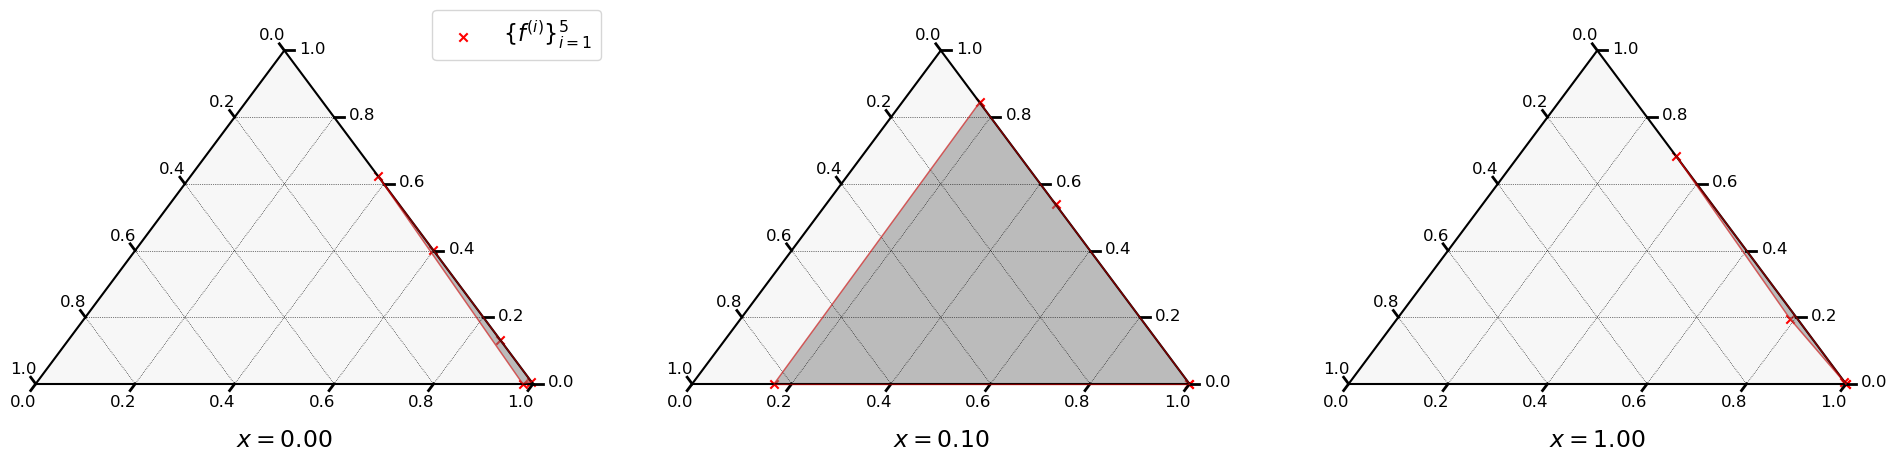

In [48]:
x_list = [0,10, 99]
fig, ax = plt.subplots(1, len(x_list), figsize=(24, 5))
for i, x in enumerate(x_list):
    tax = ternary.TernaryAxesSubplot(ax=ax[i], scale=1.0)
    p_preds_x = predictions[x, :, :]
    p_preds_2d = project_points2D(p_preds_x)
    hull = ConvexHull(p_preds_2d)
    hull_vertices = p_preds_x[hull.vertices]

    # fig, tax = ternary.figure(scale=1)
    tax.boundary()
    tax.gridlines(multiple=0.2, color="black", )
    # ticks of axes
    tax.ticks(axis='lbr', multiple=0.2, linewidth=2, offset=0.02, tick_formats="%.1f", fontsize=12)
    # remove outer axes and boxes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis("off")

    tax.scatter(
        list(map(tuple, p_preds_x)),
        marker="x",
        color="red",
        label="$\{f^{(i)}\}_{i=1}^{5}$",
    )
    for simplex in hull.simplices:
        point1 = tuple(p_preds_x[simplex[0]])
        point2 = tuple(p_preds_x[simplex[1]])
        tax.line(point1, point2, linewidth=1.0, color="red", alpha=0.5)

    polygon = Polygon(
        list(map(tuple, project_points2D(hull_vertices))),
        closed=True,
        color="grey",
        alpha=0.5,
    )
    tax.get_axes().add_patch(polygon)
    if i == 0:
        # set specific location for legend: upper right with overlap
        tax.legend(fontsize=16, loc="upper right", bbox_to_anchor=(1.1, 1.1))
    x_val = x_inst[x]
    # leave space below title
    # set title below plot
    tax.set_title(f"$x = {{{x_val: .2f}}}$", fontsize=17, pad=10, y=-0.1)
